@misc{multiobjectdatasets19,
  title={Multi-Object Datasets},
  author={Kabra, Rishabh and Burgess, Chris and Matthey, Loic and
          Kaufman, Raphael Lopez and Greff, Klaus and Reynolds, Malcolm and
          Lerchner, Alexander},
  howpublished={https://github.com/deepmind/multi-object-datasets/},
  year={2019}
}

1. In ce format se gaseste: TFRecords
2. Cate imagini contine: 100000
3. Cate tipuri de obiecte contine: 3
4. Numarul de obiecte este intre 1-11

In [ ]:
pip install torch wget pandas torchviz matplotlib numpy scipy tensorflow pickle

In [11]:
!wget -P ./data/input https://storage.googleapis.com/multi-object-datasets/clevr_with_masks/clevr_with_masks_train.tfrecords

In [53]:
# Select environment
environment = 'Jupyter' # 'Jupyter' or 'Colab'

In [57]:
import os
import torch
import torchviz
import numpy as np
import pandas as pd
from torch import nn
import tensorflow as tf
from typing import Iterator
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

if environment == 'Jupyter':
    from multi_object_datasets import clevr_with_masks
elif environment == 'Colab':
    import clevr_with_masks

In [58]:
import random

class Args():
    def __init__(self):
        # Config elements
        self.batch_size = 64
        self.test_batch_size = 64
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.9
        self.seed = 1
        self.log_interval = int(10_000 / self.batch_size)
        self.max_img_count = 100_000
        self.shuffle = False
        self.shuffle_buffer_size = 100
        self.cache_size = 7

# Instantiate a configuration
args = Args()

# Use device config
random.seed(args.seed)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [94]:
import re
import pickle
from functools import lru_cache

@lru_cache(maxsize=args.cache_size)
def load_data_file(filepath):
    """
    Receives the relative path to a file, and uses LRU caching strategy to return the result.
    """
    with open(filepath, 'rb') as handle:
        # Load the data file from disk into memory
        data = pickle.load(handle)
        
        # Iterate through the rows in the data file
        for entry in data:
            # Transform relevant columns to tensors
            for key in ['image', 'mask']:
                entry[key] = torch.Tensor(entry[key]).to(torch.uint8).squeeze(0)

            # Remove unnecessary columns
            for key in set(entry.keys()) - {'image', 'mask'}:
                del entry[key]

        # Return the processed data in Pytorch format
        return data

class SegmentationDataset(Dataset):
    def __init__(self, mode='train', imgs_per_file=1_000, shuffle=args.shuffle):
        # Specify the directory containing all data
        self._input_dir = f'./data/input/train_test_clevr_pkls'

        # Fetch the relative paths to the data files
        self._data_files = [f'{self._input_dir}/{fname}' for fname in os.listdir(self._input_dir) if re.search(mode, fname)]
        
        # Specify how many entries are in one file
        self._imgs_per_file = imgs_per_file

        # Use specified seed to shuffle the data
        if shuffle:
            random.seed(args.seed)
            random.shuffle(self._data_files)

    def __getitem__(self, index) -> torch.Tensor:
        """
        Reads the image at position 'index % imgs_per_file' in the 'index / imgs_per_file' file.
        Returns a Tensor.
        """
        # Load the file in memory using a caching strategy
        data = load_data_file(self._data_files[index // self._imgs_per_file])
        
        # Select the item at 'index % imgs_per_file'
        item = data[index % self._imgs_per_file]

        # Return a pair containing (image, mask)
        return item['image'], item['mask']

    def __len__(self):
        """
        Return the size of this dataset. 
        This is given by the number of images in all data files.
        """
        return len(self._data_files) * self._imgs_per_file
        

In [95]:
dataset = SegmentationDataset(mode='train', shuffle=True)

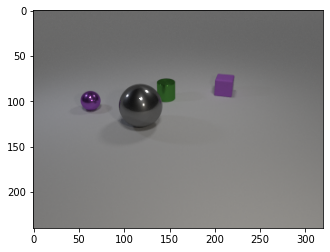

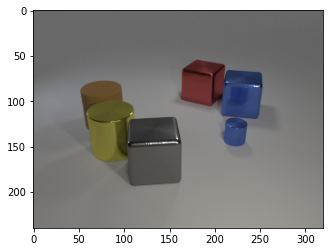

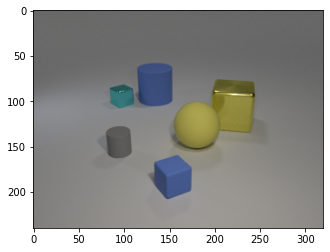

In [101]:
for idx, (image, mask) in enumerate(dataset):
    if idx >= 0 and idx <= 2:
        plt.figure()
        plt.imshow(image)